In [2]:
import pandas as pd
import numpy as np
import networkx as nx
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# read in SIDER data

drug_atc = pd.read_csv("data/drug_atc.tsv", sep='\t', header=None)
drug_atc.columns = ["drug_id", "ATC_code"]

drug_names = pd.read_csv("data/drug_names.tsv", sep='\t', header=None)
drug_names.columns = ["drug_id", "drug_name"]

drug_indications = pd.read_csv("data/meddra_all_indications.tsv", sep='\t', header=None)
drug_indications.columns = ["drug_id", "UMLS_concept_label", "method_of_detection", "concept_name", "meddra_concept_type", "UMLS_concept_meddra", "meddra_concept_name"]

drug_se = pd.read_csv("data/meddra_all_se.tsv", sep='\t', header=None)
drug_se.columns = ["drug_id", "drug_id_stereo", "UMLS_concept_label", "meddra_concept_type", "UMLS_concept_meddra", "side_effect_name"]

meddra = pd.read_csv("data/meddra.tsv", sep='\t', header=None)
meddra.columns = ["UMLS_concept_id", "meddra_id", "meddra_concept_type", "side_effect_name"]

In [4]:
# format drug df

drug = pd.merge(drug_se, drug_names, how="left", left_on="drug_id", right_on="drug_id")

## SIDER Data EDA


In [5]:
# total num drugs

len(drug.drug_name.unique())

1347

In [6]:
# average number of side effects per drug

drug_to_se = drug.groupby("drug_id", as_index=False).agg({"side_effect_name": list, "UMLS_concept_meddra": list})
drug_to_se['unique_se'] = [len(np.unique(x)) for x in drug_to_se.UMLS_concept_meddra]

np.mean(drug_to_se.unique_se)

113.88181818181818

In [7]:
# find all heart-related side effects
c = []

for i in drug.side_effect_name.unique():
    if "cardi" in i.lower():
        c.append(i)

In [8]:
# num heart-related side effects

len(c)

132

In [9]:
# num drugs with heart-related side effects

cd = drug[drug['side_effect_name'].isin(c)].drug_id.unique()
len(cd)

929

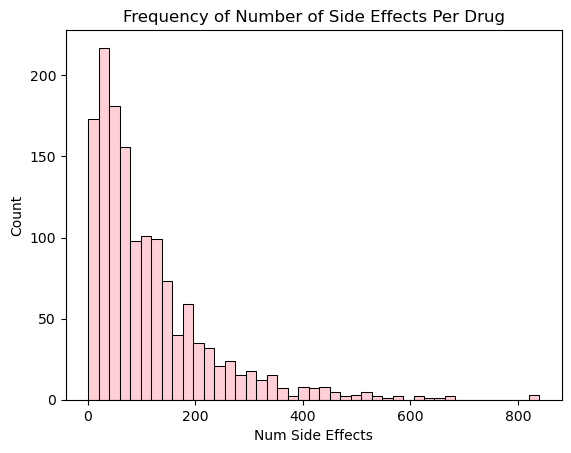

In [12]:
# histogram of number of side effects for each drug

sns.histplot(drug_to_se, x="unique_se", color='pink')
plt.xlabel("Num Side Effects")
plt.title("Frequency of Number of Side Effects Per Drug");

4.330462863293865


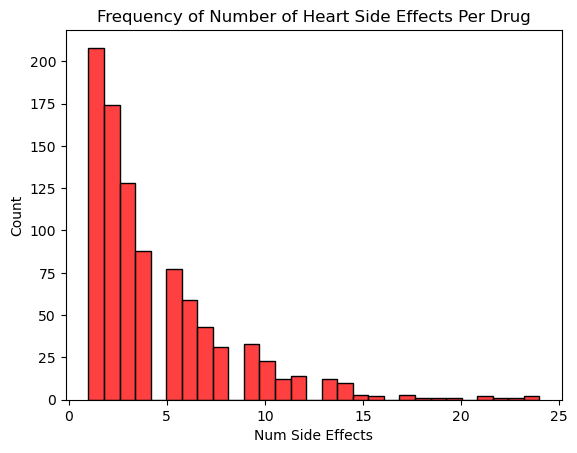

In [13]:
# frequency of heart side effects per drug

heart_se = drug[drug["side_effect_name"].isin(c)]
heart_drug_to_se = heart_se.groupby("drug_id", as_index=False).agg({"side_effect_name": list, "UMLS_concept_meddra": list})
heart_drug_to_se['unique_se'] = [len(np.unique(x)) for x in heart_drug_to_se.UMLS_concept_meddra]

print(np.mean(heart_drug_to_se.unique_se))

# histogram of number of heart side effects for each drug

sns.histplot(heart_drug_to_se, x="unique_se", color='red')
plt.xlabel("Num Side Effects")
plt.title("Frequency of Number of Heart Side Effects Per Drug");

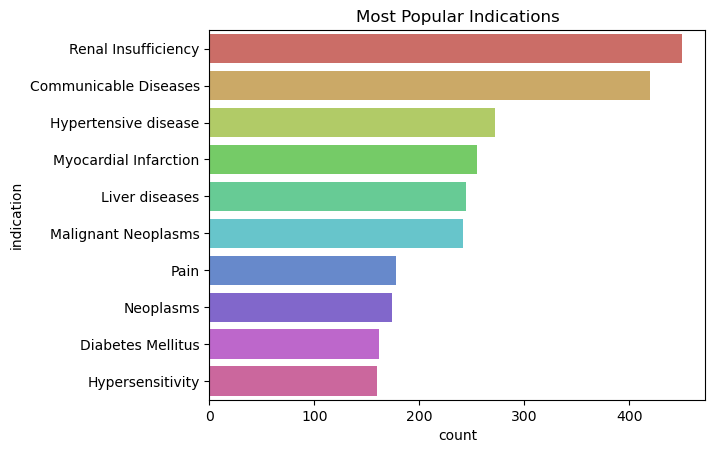

In [14]:
# most common drug indications

indications = Counter(drug_indications.concept_name)
i_df = pd.DataFrame({"indication": indications.keys(), "count": indications.values()})
i_df = i_df.sort_values("count", ascending=False)


sns.barplot(i_df.head(10), y="indication", x="count", \
            palette = sns.color_palette("hls", 10)) \
            .set(title="Most Popular Indications");

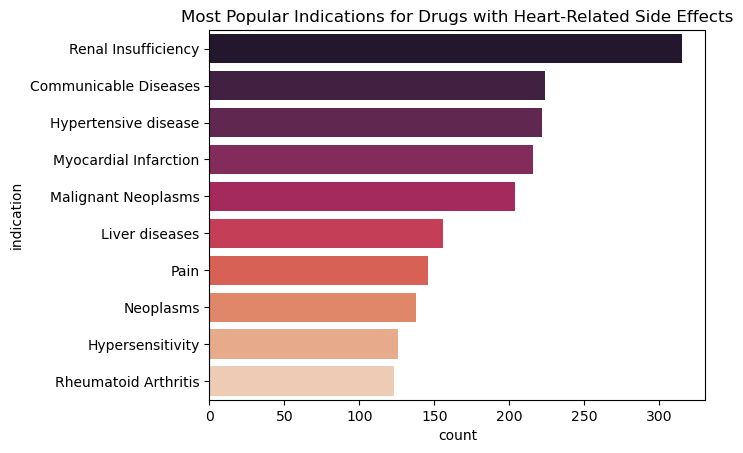

In [15]:
# most common drug indications for drugs with heart-side effects

heart_drug_indications = Counter(drug_indications[drug_indications['drug_id'].isin(heart_se.drug_id.unique())].concept_name)
hi_df = pd.DataFrame({"indication": heart_drug_indications.keys(), "count": heart_drug_indications.values()})
hi_df = hi_df.sort_values("count", ascending=False)


sns.barplot(hi_df.head(10), y="indication", x="count", \
            palette = sns.color_palette("rocket", 10)) \
            .set(title="Most Popular Indications for Drugs with Heart-Related Side Effects");

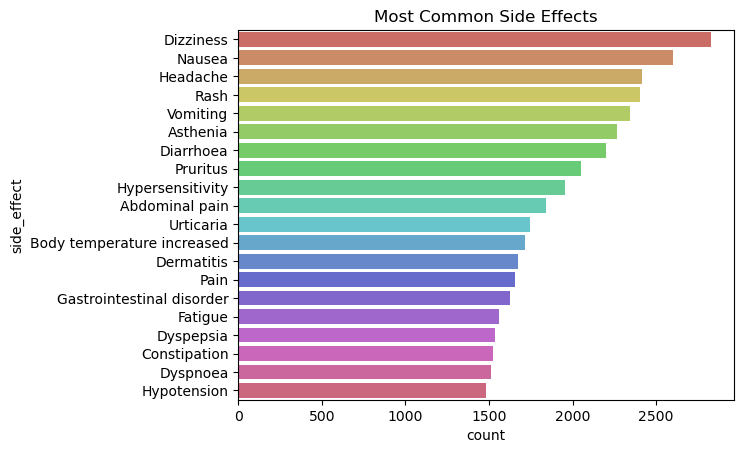

In [16]:
# most common side effects

se = Counter(drug_se.side_effect_name)
se_df = pd.DataFrame({"side_effect": se.keys(), "count": se.values()})
se_df = se_df.sort_values("count", ascending=False)


sns.barplot(se_df.head(20), y="side_effect", x="count", \
            palette = sns.color_palette("hls", 20)) \
            .set(title="Most Common Side Effects");

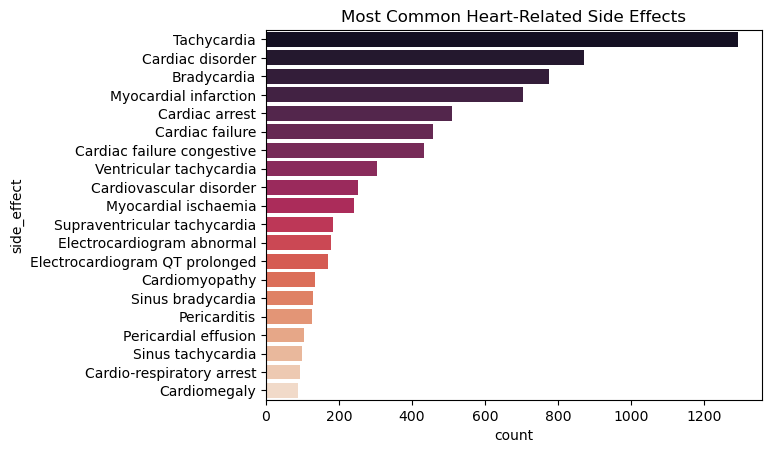

In [17]:
# most common heart side effects

heart_drug_se = Counter(heart_se.side_effect_name)
heart_se_df = pd.DataFrame({"side_effect": heart_drug_se.keys(), "count": heart_drug_se.values()})
heart_se_df = heart_se_df.sort_values("count", ascending=False)


sns.barplot(heart_se_df.head(20), y="side_effect", x="count", \
            palette = sns.color_palette("rocket", 20)) \
            .set(title="Most Common Heart-Related Side Effects");

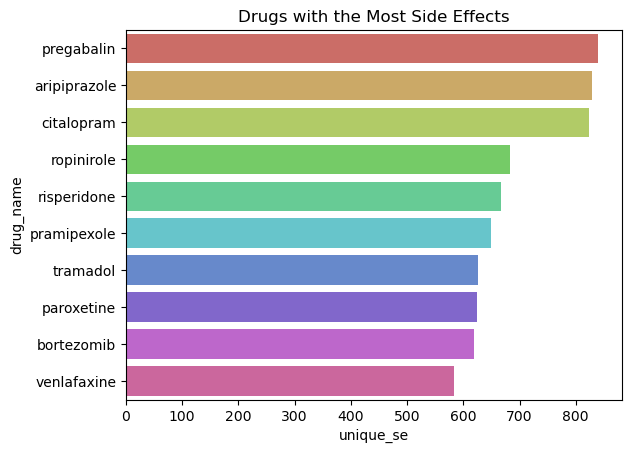

In [18]:
# drugs with the most side effects

most_se = drug_to_se.sort_values("unique_se", ascending=False).head(10)
most_se_names = pd.merge(most_se, drug_names, how="left", left_on="drug_id", right_on="drug_id")
most_se_names["unique_side_effects"] = [np.unique(s) for s in most_se_names.side_effect_name]

sns.barplot(most_se_names, x="unique_se", y="drug_name", \
    palette = sns.color_palette("hls", 10)) \
    .set(title="Drugs with the Most Side Effects");


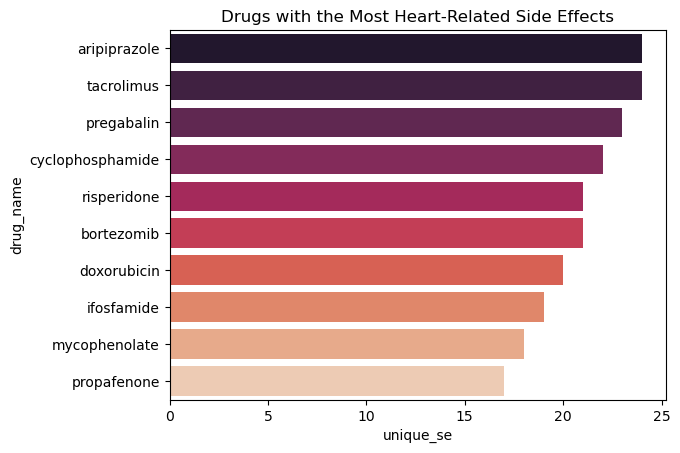

In [19]:
# drugs with the most heart-related side effects

most_se_heart = heart_drug_to_se.sort_values("unique_se", ascending=False).head(10)
most_se_heart_names = pd.merge(most_se_heart, drug_names, how="left", left_on="drug_id", right_on="drug_id")
most_se_heart_names["unique_side_effects"] = [np.unique(s) for s in most_se_heart_names.side_effect_name]

sns.barplot(most_se_heart_names, x="unique_se", y="drug_name", \
    palette = sns.color_palette("rocket", 10)) \
    .set(title="Drugs with the Most Heart-Related Side Effects");


In [20]:
# network example of implications - drugs - SEs
G = nx.Graph()

In [21]:
sns.color_palette("hls", 5)

[(0.86, 0.3712, 0.33999999999999997),
 (0.7247999999999999, 0.86, 0.33999999999999997),
 (0.33999999999999997, 0.86, 0.5792000000000002),
 (0.33999999999999997, 0.5167999999999995, 0.86),
 (0.7871999999999999, 0.33999999999999997, 0.86)]

In [25]:
# get implications and drugs

imp_drug = drug_indications[["drug_id", "meddra_concept_name"]].drop_duplicates(subset=["drug_id", "meddra_concept_name"])
imp_drug_names = pd.merge(imp_drug, drug_names, on="drug_id", how="left")

# perform on a sample of 3 drugs and top 5 most common 
sample_drugs = most_se_names['drug_name'].head(5)
sample_imp = dict(Counter(imp_drug_names[imp_drug_names["drug_name"].isin(sample_drugs)].meddra_concept_name).most_common(10)).keys()
mini_imp_drugs = imp_drug_names[imp_drug_names["drug_name"].isin(sample_drugs)]
mini_imp_drugs = mini_imp_drugs[mini_imp_drugs["meddra_concept_name"].isin(sample_imp)].reset_index()

# get drugs and SEs
se_drug_name = pd.merge(drug_se[drug_se["drug_id"].isin(drug_names[drug_names["drug_name"].isin(sample_drugs)]["drug_id"])], \
         drug_names, how="left", left_on="drug_id", right_on="drug_id")[["drug_name", "side_effect_name"]] \
    .drop_duplicates(subset=['drug_name', 'side_effect_name'])
sample_se = dict(Counter(se_drug_name.side_effect_name).most_common(10)).keys()
mini_se_drugs = se_drug_name[se_drug_name["drug_name"].isin(sample_drugs)]
mini_se_drugs = mini_se_drugs[mini_se_drugs["side_effect_name"].isin(sample_se)].reset_index()

# create drug color map for edges
color_dict = {}
for d in range(len(sample_drugs)):
    color_dict[sample_drugs[d]] = sns.color_palette("hls", 5)[d]

id_edges = []

# add implication - drug edges to graph
for i in range(len(mini_imp_drugs)):
    x = mini_imp_drugs['meddra_concept_name'][i]
    y = mini_imp_drugs['drug_name'][i]
    id_edges.append((x, y))

ds_edges = []

# add drug - SE edges to graph
for j in range(len(mini_se_drugs)):
    x = mini_se_drugs['drug_name'][j]
    y = mini_se_drugs['side_effect_name'][j]
    ds_edges.append((x, y))


In [26]:
# network example of implications - drugs - SEs
BG = nx.Graph()

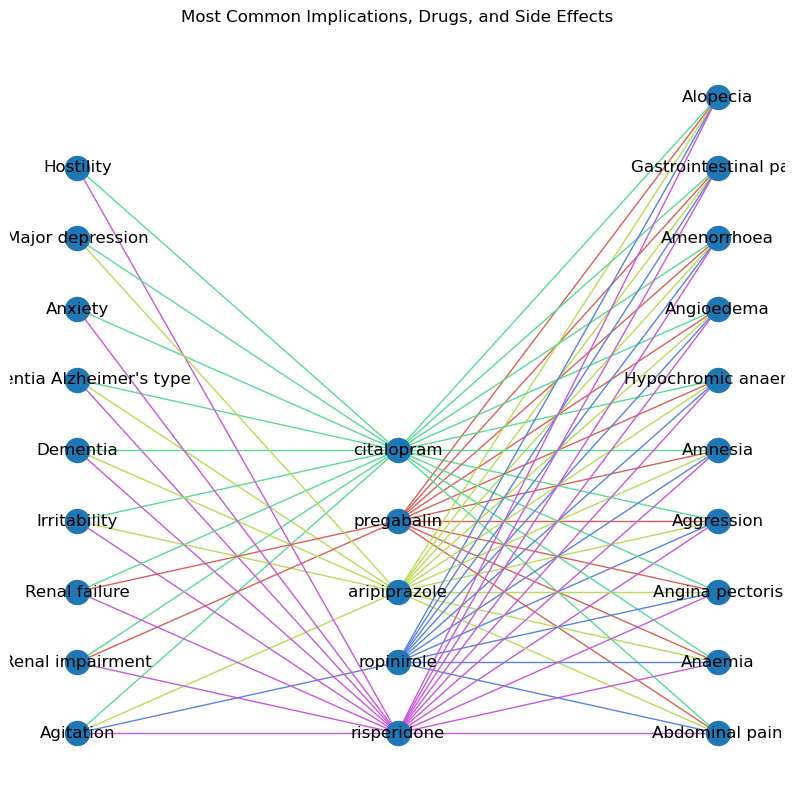

In [27]:
# add nodes here
BG.add_nodes_from(sample_imp, bipartite=0)
BG.add_nodes_from(sample_drugs, bipartite=1)
BG.add_nodes_from(sample_se, bipartite=2)

# add edges here
BG.add_edges_from(id_edges)
BG.add_edges_from(ds_edges)


nodes = BG.nodes()
# for each of the parts create a set 
nodes_0  = set([n for n in nodes if  BG.nodes[n]['bipartite']==0])
nodes_1  = set([n for n in nodes if  BG.nodes[n]['bipartite']==1])
nodes_2  = set([n for n in nodes if  BG.nodes[n]['bipartite']==2])

# set the location of the nodes for each set
pos = dict()
pos.update( (n, (1, i)) for i, n in enumerate(nodes_0) ) # put nodes from X at x=1
pos.update( (n, (2, i)) for i, n in enumerate(nodes_1) ) # put nodes from Y at x=2
pos.update( (n, (3, i)) for i, n in enumerate(nodes_2) ) # put nodes from X at x=1

# set colors
edge_colors = []
for pair in BG.edges:
    if pair[0] in color_dict.keys():
        edge_colors.append(color_dict[pair[0]])
    else:
        edge_colors.append(color_dict[pair[1]])

plt.figure(figsize=(10, 10)) 
plt.title("Most Common Implications, Drugs, and Side Effects")
nx.draw(BG, pos=pos, with_labels=True, edge_color=edge_colors)

# Extracting only the heart-related side effects and drugs to csv

In [49]:
# all heart-related side effects

c

['Cardiovascular disorder',
 'Tachycardia',
 'Electrocardiogram abnormal',
 'Cardiac disorder',
 'Cardiac arrest',
 'Myocardial infarction',
 'Cardiac failure',
 'Cardiac failure right',
 'Bradycardia',
 'Sinus tachycardia',
 'Ventricular tachycardia',
 'Myocardial ischaemia',
 'Electrocardiogram ST segment elevation',
 'Electrocardiogram ST segment depression',
 'Non-sustained ventricular tachycardia',
 'Cardiac failure congestive',
 'Pneumopericardium',
 'Supraventricular tachycardia',
 'Electrocardiogram ST segment',
 'Electrocardiogram QRS complex',
 'Cardiac flutter',
 'Decompensation cardiac',
 'Cardiomegaly',
 'Pericarditis',
 'Cardio-respiratory arrest',
 'Cardiotoxicity',
 'Cardiomyopathy',
 'Non-cardiogenic pulmonary oedema',
 'Electrocardiogram U wave present',
 'Electrocardiogram U-wave abnormality',
 'Non-cardiac chest pain',
 'Cardiac murmur',
 'Congestive cardiomyopathy',
 'Myocarditis',
 'Pericardial effusion',
 'Cardiogenic shock',
 'Electrocardiogram QRS complex abnor

In [45]:
len(c)

132

In [50]:
# num drugs that give heart-related side effects

len(drug_names[drug_names['drug_id'].isin(cd)].drug_name.unique())

887

In [51]:
# save drugs that give heart se's to csv

drug_names[drug_names['drug_id'].isin(cd)].to_csv("data/drugs_with_heart_se.csv", index=None)

In [59]:
# save the heart-related drugs and their heart-related side effects

drug[drug["side_effect_name"].isin(c)][['drug_name', 'side_effect_name']].drop_duplicates(['drug_name', 'side_effect_name']).to_csv("data/heart_drugs_with_heart_se.csv", index=False)